### The Challenge: Build a large-scale image search engine!

You and your team of **three Cornell Tech students** are surely on the path to fame and fortune! You have been recruited by Google to disrupt Google Image Search by building a better search engine using novel statistical learning techniques.

The specifications are simple: We need a way to **search for relevant images** given a natural language query. For instance, if a user types "dog jumping to catch frisbee," your system will **rank-order the most relevant images** from a large database.

---


**During training**, you have a dataset of 10,000 samples. 

Each sample has the following data available for learning:
- A 224x224 JPG image.
- A list of tags indicating objects appeared in the image.
- Feature vectors extracted using [Resnet](https://arxiv.org/abs/1512.03385), a state-of-the-art Deep-learned CNN (You don't have to train or run ResNet -- we are providing the features for you). See [here](http://ethereon.github.io/netscope/#/gist/b21e2aae116dc1ac7b50) for the illustration of the ResNet-101 architecture. The features are extracted from pool5 and fc1000 layer.
- A five-sentence description, used to train your search engine.

**During testing**, your system matches a single five-sentence description against a pool of 2,000 candidate samples from the test set. 

Each sample has:
- A 224x224 JPEG image.
- A list of tags for that image.
- ResNet feature vectors for that image.

**Output**:
For each description, your system must rank-score each testing image with the likelihood of that image matches the given sentence. Your system then returns the name of the top 20 relevant images, delimited by space. See "sample_submission.csv" on the data page for more details on the output format.

**Evaluation metric**:
There are 2,000 descriptions, and for each description, you must compare against the entire 2,000-image test set. That is, rank-order test images for each test description. We will use **MAP@20** as the evaluation metric. If the corresponding image of a description is among your algorithm's 20 highest scoring images, this metric gives you a certain score based on the ranking of the corresponding image. Please refer to the evaluation page for more details. Use all of your skills, tools, and experience. It is OK to use libraries like numpy, scikit-learn, pandas, etc., as long as you cite them. Use cross-validation on training set to debug your algorithm. Submit your results to the Kaggle leaderboard and send your complete writeup to CMS. The data you use --- and the way you use the data --- is completely up to you.

**Note**:
The best teams of **three Cornell Tech students** might use visualization techniques for debugging (e.g., show top images retrieved by your algorithm and see whether they make sense or not), preprocessing, a nice way to compare tags and descriptions, leveraging visual features and combining them with tags and descriptions, supervised and/or unsupervised learning to best understand how to best take advantage of each data source available to them.

---

**File descriptions**:

- images_train - 10,000 training images of size 224x224.
- images_test - 2,000 test images of size 224x224.
- tags_train - image tags correspond to training images. Each image have several tags indicating the human-labeled object categories appear in the image, in the form of "supercategory:category".
- tags_test - image tags correspond to test images. Each image have several tags indicating the human-labeled object categories appear in the image, in the form of "supercategory:category".
features_train - features extracted from a pre-trained Residual Network (ResNet) on training set, including 1,000 dimensional feature from classification layer (fc1000) and 2,048 dimensional feature from final convolution layer (pool5). Each dimension of the fc1000 feature corresponds to a WordNet synset here.
- features_test - features extracted from the same Residual Network (ResNet) on test set, including 1,000 dimensional feature from classification layer (fc1000) and 2,048 dimensional feature from final convolution layer (pool5).
- descriptions_train - image descriptions correspond to training images. Each image have 5 sentences for describing the image content.
- descriptions_test - image descriptions for test images. Each image have 5 sentences for describing the image content. Notice that one test description corresponds to one test image. The task you need to do is to return top 20 images in test set for each test description.
- sample_submission.csv - a sample submission file in the correct format.

---


In [25]:
import os
import sys
import csv
import nltk
import random
import operator
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.cm as cm
from string import punctuation
from nltk.corpus import stopwords
from matplotlib import pylab as plt
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Conor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%matplotlib inline

In [19]:
# Define paths for training/testing data
my_path = os.getcwd()
tags_train_path = os.path.join(my_path, 'tags_train')
tags_test_path  = os.path.join(my_path, 'tags_test')
desc_train_path = os.path.join(my_path, 'descriptions_train')
desc_test_path  = os.path.join(my_path, 'descriptions_test')
image_train_path = os.path.join(my_path, 'images_train')
image_test_path  = os.path.join(my_path, 'images_test')
features_train_res_path = os.path.join(my_path, 'features_train/features_resnet1000_train.csv')
features_test_res_path  = os.path.join(my_path, 'features_test/features_resnet1000_test.csv')
features_train_res_int_path = os.path.join(my_path, 'features_train/features_resnet1000intermediate_train.csv')
features_test_res_int_path  = os.path.join(my_path, 'features_test/features_resnet1000intermediate_test.csv')

# Sort files in ascending order
def order_keys(text):
    return int(text.split('.')[0])

# Read/return list of images within a folder
def read_images(folder_path):
    images = []
    image_files = os.listdir(folder_path)
    image_files.sort(key = order_keys)
    for image_file in image_files:
        # Open each image file
        im = Image.open(os.path.join(folder_path, image_file), 'r')
        # Convert to an np array
        images.append(np.asarray(im))
        # Close the file
        im.close()
    return images

# Read/return lists of elements from files within a folder
def read_files(folder_path):
    elements = []
    files = os.listdir(folder_path)
    files.sort(key = order_keys)
    for f in files:
        # Open each text file. Strip leading/trailing whitespace
        lines = [line.strip() for line in open(os.path.join(folder_path, f))]
        elements.append(' '.join(lines))
    return elements

# Read/return list of features
def read_features(file_path):
    reader = csv.reader(open(file_path), delimiter=",")
    features = sorted(reader, key = lambda row: int(row[0].split('/')[1].split('.')[0]))
    # Skip the image name
    for ind, image in enumerate(features):
        features[ind] = image[1:]
    return features

# Print random rows from a dataframe
def aux_print(df, num_rows):    
    for index in range(num_rows):
        rand_index = random.randrange(0, len(df.index))
        row = df.iloc[rand_index]
        print "Image num. {}".format(rand_index)
        plt.imshow(row['image'])
        plt.show()
        print row['tag']
        print row['desciption']
        print row['resnet_feats'][:10]
        print row['resnet_feats_int'][:10]

# Transform input to lowercase
def to_lowercase(sent):
    return sent.lower()

# Lemmatize input
lemmatizer = WordNetLemmatizer()
def lemmatize(sent):
    words = sent.split()
    return [lemmatizer.lemmatize(word) for word in words]
    
# Stem input
stemmer = SnowballStemmer('english')
def stem(sent):
    words = sent.split()
    return [stemmer.stem(word) for word in words]
    
# Remove stop words from input
def remove_stopwords(sent):
    stops = set(stopwords.words("english"))
    words = sent.split()
    return [word for word in words if not word in stops]

# Remove special characters from input
def remove_special_chars(sent):
    re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", sent)
#     return sent


Image num. 7267


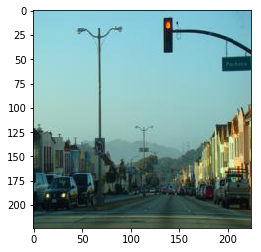

outdoor:traffic light vehicle:car vehicle:truck
cars that are stopped at a traffic light a traffic light on the road with many vehicle A busy street with many cars, buildings and stop light. a big street with houses all around it A red light over a city street in a neighborhood.
['-2.618931293487549', '-2.9194087982177734', '-2.8624653816223145', '-4.3581743240356445', '-2.0714588165283203', '1.8630906343460083', '-1.7992444038391113', '-1.3220679759979248', '-1.6770390272140503', '-0.7851053476333618']
['0.625273585319519', '0.2979341745376587', '0.38557901978492737', '0.30452871322631836', '1.2216179370880127', '0.13039571046829224', '0.39284682273864746', '0.18356488645076752', '0.18110200762748718', '0.32513028383255005']
Image num. 3467


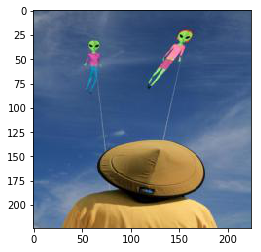

person:person sports:kite
A person in a yellow outfit flying two alien kites. a person flying two kites in the shape of aliens A person looks up at two kites shaped like extra terrestrials. A person flies two kites on a windy day. A person flying two alien kites in the air
['1.822400689125061', '-1.6583278179168701', '-0.10689965635538101', '1.755345106124878', '-0.20862889289855957', '1.8955698013305664', '-2.123713731765747', '-3.2316646575927734', '-3.625129222869873', '-4.654057502746582']
['2.1175966262817383', '0.17344386875629425', '0.22465166449546814', '0.611492395401001', '0.08019442111253738', '0.29659876227378845', '0.03979843109846115', '0.6683875322341919', '0.43731579184532166', '0.18813961744308472']


In [7]:
# Read in the training data
train_df = pd.DataFrame()
train_df['tag'] = read_files(tags_train_path)
train_df['image'] = read_images(image_train_path)
train_df['desciption'] = read_files(desc_train_path)
train_df['resnet_feats'] = read_features(features_train_res_path)
train_df['resnet_feats_int'] = read_features(features_train_res_int_path)


In [26]:
# Preprocess the training data
for index, desc in enumerate(train_df['desciption']):
    print desc
    desc = to_lowercase(desc)
    print desc
#     desc = lemmatize(desc)
#     print desc
    desc = stem(desc)
    print desc
    desc = remove_stopwords(desc)
    print desc
    desc = remove_special_chars(desc)
    print desc


The skateboarder is putting on a show using the picnic table as his stage. A skateboarder pulling tricks on top of a picnic table. A man riding on a skateboard on top of a table. A skate boarder doing a trick on a picnic table. A person is riding a skateboard on a picnic table with a crowd watching.
the skateboarder is putting on a show using the picnic table as his stage. a skateboarder pulling tricks on top of a picnic table. a man riding on a skateboard on top of a table. a skate boarder doing a trick on a picnic table. a person is riding a skateboard on a picnic table with a crowd watching.
[u'the', u'skateboard', 'is', u'put', 'on', 'a', u'show', u'use', u'the', u'picnic', u'tabl', 'as', u'his', u'stage.', 'a', u'skateboard', u'pull', u'trick', 'on', u'top', 'of', 'a', u'picnic', u'table.', 'a', u'man', u'ride', 'on', 'a', u'skateboard', 'on', u'top', 'of', 'a', u'table.', 'a', u'skate', u'boarder', u'do', 'a', u'trick', 'on', 'a', u'picnic', u'table.', 'a', u'person', 'is', u'rid

AttributeError: 'list' object has no attribute 'split'

In [ ]:
# Read in the testing data
test_df = pd.DataFrame()
test_df['tag'] = read_files(tags_test_path)
test_df['image'] = read_images(image_test_path)
test_df['desciption'] = read_files(desc_test_path)
test_df['resnet_feats'] = read_features(features_test_res_path)
test_df['resnet_feats_int'] = read_features(features_test_res_int_path)


Image num. 1405


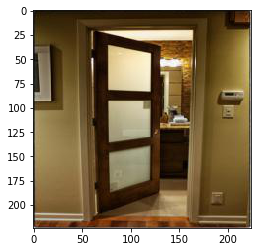

kitchen:bottle
Partially open door leading to a kitchen from a hallway.A bathroom with the lights on visible through a slightly ajar door.The bathroom door has three panels of frosted glass.The open door to the bathroom is shown here.Outside shot of a restroom showing the door partially open.
['-1.9897370338439941', '0.05231553316116333', '-2.9022421836853027', '-2.615691900253296', '-1.6712596416473389', '0.7852491140365601', '-4.48091459274292', '-2.0156428813934326', '-1.927566409111023', '-2.917060375213623']
['0.013013572432100773', '0.6189833283424377', '0.31745317578315735', '0.06138663738965988', '0.17090687155723572', '0.16551367938518524', '0.09803489595651627', '0.32612255215644836', '0.5888402462005615', '0.4595942497253418']
Image num. 8030


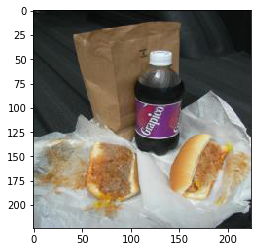

kitchen:bottlefood:sandwichfood:hot dog
A lunch of two chili dogs and a grape soda.A brown lunch bag with grape soda, and two hot dogs with toppings.A wooden table with two hotdogs in wrapping and a bottle of soda.Food on paper with a drink and paper bagtwo hotdogs on white sheets next to a grape soda from a brown bag
['0.8638343214988708', '1.9828662872314453', '-2.2519116401672363', '-2.3720197677612305', '-2.323298692703247', '0.7543110251426697', '-5.152703762054443', '-0.03511255234479904', '1.9215583801269531', '-2.6041553020477295']
['0.35784822702407837', '1.007525086402893', '0.3413268029689789', '0.8431667685508728', '0.060723669826984406', '0.5322315692901611', '0.4939015507698059', '0.7672791481018066', '0.1888938993215561', '0.16748671233654022']


In [ ]:
# Output results to CSV

# with open('test_results.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',')
#     writer.writerow(['Description_ID','Top_20_Image_IDs'])


---

In [ ]:
## OLD STUFF

# Some of the training data did not have space after punctuation and was considered together as a word
# To account for this, punctuations were replaced with a blankspace to be splitted later. The words in sentences were converted to lowercase as well
# def fixpunct(s):
#     new_sent = ''
#     for i in s:
#         if i not in string.punctuation:
#             new_sent += i
#         else:
#             new_sent += ' '
#     return new_sent.lower()


# # Iterate through the training data and generate a list of unique words
# uniquewords1 = []
# lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
# for sentence in training_data1:
#     sentencefixed = fixpunct(sentence)
#     tokens = nltk.word_tokenize(sentencefixed)
#     tokens = [lmtzr.lemmatize(word, 'v') for word in tokens]
#     tokens = [word for word in tokens if word not in stopset]
#     for word in tokens:
#         if word not in uniquewords1:
#             uniquewords1.append(word)
            
    
    
#     Clustering is useful when data is clumpy. (K-means)

# Random Decision Forests (also called Random Forests) were first proposed as a technique for handwritten digit classification.
# - Might want to get misclassification error, Gini index, cross-entropy/deviance from trees

# K-Medoids is when we don't have access to the vector space from which dissimilarities where generated. 

# PCA will give a dimensionality reduced approximated representation. It can help in denoising the data. But it is useful for manifoldy data, and will not benefit us. 

# Could use Niave Bayes with BoW, where the bag has normalized frequencies. 

# Preprocessing the desciption vectors:
# - Lowercase all
# - Remove punctuation
# - Vectorize a text corpus
#   - Coefficient could be binary, based on word count, based on tf-idf
#   - https://keras.io/preprocessing/text/
# - Try lematize, stemming, to show results
#   - Check: https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings

# Read this about which layers to use: https://arxiv.org/pdf/1512.03385.pdf


# TFID
# LSTM

**Preprocessing**:
- Remove stop words
- Remove stemming
- Remove special characters 
- Lowercase everything
- https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

**Postprocessing (?)**:
- log-normalization
- l1 normalization
- l2 normalization
- Standardize the data by subtracting the mean and dividing by the variance.

**Clustering descriptions**:
- Bag of words, 2-gram, maybe PCA
- With BoW, use tf–idf
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e

**Clustering images**:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- Random Decision Forests
- K-means or K-medoids
- PCA is good for reducing noise, but the input data should be "manifoldy", we are probably dealing with "clumpy"
- Niave bayes

**CNN/RNN links**:
- https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
- http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://medium.freecodecamp.org/learn-to-build-a-convolutional-neural-network-on-the-web-with-this-easy-tutorial-- 2d617ffeaef3
- https://blog.insightdatascience.com/the-unreasonable-effectiveness-of-deep-learning-representations-4ce83fc663cf
- https://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model
- https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624
